#Multithreading, Multiprocessing, and Subprocessing
##    - Chris Sterling

- This is a primer to help you get started, not an all-encompassing guide
- I'll be posting this, so no need to frantically write code
- Here and there, I had to do some magic behind the scenes so that IPython notebook gave expected behavior - look at the notebook for more info

##A function

In [24]:
def count_down(n):
    while n > 0:
        n-=1

COUNT = 500000000

Suppose we have a CPU bound function

In [25]:
import time
start = time.time()

count_down(COUNT)

end = time.time()
nothing = end-start
print(nothing)

22.7928500175


# Concurrency
- What if we want to split the work?

#Libraries
- threading
- multiprocessing
- subprocessing

# Threads
- Wrap around C's PThread library
- Significantly slowed down significantly because of the GIL
- 2 threads - 1/2 the time? ...Sometimes...
- Basic operations:
 - `Thread(target=function_pointer, args=(fxn_arguments))`
 - `.start()`
 - `.join()`
 

In [26]:
from threading import Thread

# Setup the worker functions
t1 = Thread(target=count_down, args=(COUNT//2,))
t2 = Thread(target=count_down, args=(COUNT//2,))

start = time.time()

t1.start; t2.start()
t1.join; t2.join()

end = time.time()
two_thread = end-start
print "Nothing:\t%.4f" % nothing
print "2 Threads:\t%.4f" % two_thread

Nothing:	22.7929
2 Threads:	11.3605


# More Threads, More Power!
- Spawn 10 threads all counting
- 1/10th the time...right?

In [27]:
NUM_THREADS = 10
threads = [Thread(target=count_down, args=(COUNT//NUM_THREADS,)) for x in range(NUM_THREADS)]
start = time.time()

# Run thread pool
for t in threads:
    t.start()

# Wait for the completed threads to exit
for t in threads:
    t.join()
    
end = time.time()
multi_thread = end - start
print "Nothing:\t%.4f" % nothing
print "2 Threads:\t%.4f" % two_thread
print "%d Threads:\t%.4f" % (NUM_THREADS, multi_thread)

Nothing:	22.7929
2 Threads:	11.3605
10 Threads:	57.5292


##Uh...What?

# What it's supposed to look like:
![Fork Join Flowchart](http://5l3vgw.bay.livefilestore.com/y1prpgpboRXSzjQVnNYycq6GJuJ8R8HJIlojyRLhYinSz8MbLbSRl-3NN9tSD_qBRNoLp4SGLDZHIzUL0yvuqRj9GczCqOudgK_/Fork-Join%20flowchart.jpg)

#What it actually looks like
![Threads and Puppies](http://s.quickmeme.com/img/8a/8a7e56c7935f096a8fbb6c536ed532ff32790c88ff957c85352ebe1ca462ce47.png)

#What it actually looks like
###The CPython GIL (Global Interpreter Lock)
![CPython GIL](http://cdn1.eveonline.com/community/devblog/2011/tasktree.png)

####What if we want true concurrency though?

- In order to have a truly multi-threaded program, you need a multi-threaded language
- CPython 2 can only execute one line of code at a time because it passes around a single-threaded resource to access the Global Interpreter
- Only one line of code can really be executed because of this

#Forking!
- The C-like way of spawning a child

In [46]:
import os
a = 0

newpid = os.fork()

if newpid == 0:
    print 'A new child (%d) is born!' % os.getpid( )
    a+=1
    print "The value of a in the child is %d" % a
    os._exit(0)
else:
    pids = (os.getpid(), newpid)
    time.sleep(5)
    print "parent: %d, child: %d" % pids
    print "The value of a in the parent is %d" % a

parent: 829, child: 1021
The value of a in the parent is 0
A new child (1021) is born!
The value of a in the child is 1


#Fork the work:

In [47]:
import os
import time
start = time.time()

newpid = os.fork()
if newpid==0:
    count_down(COUNT/2)
    os._exit(0)
else:
    count_down(COUNT/2)

end = time.time()
forking = end-start
print "Nothing:\t%.4f" % nothing
print "Forking:\t%.4f" % forking

Nothing:	22.7929
Forking:	11.4259


# Multiprocessing

In [30]:
import multiprocessing as mp
import random
import string

start = time.time()

p1 = mp.Process(target=count_down, args=(COUNT//2,))
p2 = mp.Process(target=count_down, args=(COUNT//2,))
p1.start(); p2.start()
p1.join(); p2.join()

end = time.time()
two_proc = end - start
print "Nothing:\t%.4f" % nothing
print "Forking:\t%.4f" % forking
print "2 Processes:\t%.4f" % two_proc

Nothing:	22.7929
Forking:	14.6486
2 Processes:	13.5605


######Modified from http://sebastianraschka.com/Articles/2014_multiprocessing_intro.html#Multi-Threading-vs.-Multi-Processing

# More processes...more power?
Spawn 10 processes all counting

In [31]:
NUM_PROCS = 10
processes = [mp.Process(target=count_down, args=(COUNT//NUM_PROCS,)) for x in range(NUM_PROCS)]
start = time.time()

# Run processes
for p in processes:
    p.start()

# Wait for the completed processes to exit
for p in processes:
    p.join()
    
end = time.time()
multi_proc = end - start
print "Nothing:\t%.4f" % nothing
print "Forking:\t%.4f" % forking
print "2 Processes:\t%.4f" % two_proc
print "%d Processes:\t%.4f" % (NUM_PROCS, multi_proc)

Nothing:	22.7929
Forking:	14.6486
2 Processes:	13.5605
10 Processes:	13.6505


# A Comparison

In [32]:
print "Nothing:\t%.4f" % nothing
print "2 Threads:\t%.4f" % two_thread
print "%d Threads:\t%.4f" % (NUM_THREADS, multi_thread)
print "Forking:\t%.4f" % forking
print "2 Processes:\t%.4f" % two_proc
print "%d Processes:\t%.4f" % (NUM_PROCS, multi_proc)

Nothing:	22.7929
2 Threads:	11.3605
10 Threads:	57.5292
Forking:	14.6486
2 Processes:	13.5605
10 Processes:	13.6505


# But they do the same thing!
...Don't they?

- Something I personally still struggle with is when to use which
- Downside of processing is much more gets copied
- Remember, this is for threading in Python, not just in C

# When do I use which?
- Processes copy resources (heavier)
- Threads share resources (lighter)
- Depends on what you're trying to do

#Process
![Process System Diagram](http://www.w3.org/People/Frystyk/thesis/Process.gif)

#Thread
![Thread System Diagram](http://www.w3.org/People/Frystyk/thesis/MultiStackThread.gif)

# Then there's subprocess
 - Subprocess doesn't carry around as much as multiprocess
  - Carries the environment, but doesn't copy the active variables
 - Great for calling external commands
 
### Basic Example:

In [33]:
import subprocess
ls_output = subprocess.check_output(['ls'])
print(ls_output)

MandelbrotFractal.png
Threads and Processes in Python 2.ipynb
a_new_file
custom.css
install-support.ipynb
multi_threaded_scraping.py
notebook-slideshow-example.ipynb
reveal.js
scraping.ipynb
scraping.py
scraping.pyc



### Weakness
- .check_output is 'blocking'

#### What if we wanted to get the data back concurrently though?

The subprocess module is for spawning processes and doing things with their input/output - not for running functions.

# We can use Popen()
- Non-blocking

###Basic Example

In [34]:
from subprocess import Popen, PIPE
import sys
command = "ls -l".split(" ")
proc = Popen(command, cwd='/', stdout=PIPE, stderr=PIPE)

while True:
    out = proc.stdout.read(1)
    if out == '' and proc.poll() != None:
        break
    if out != '':
        sys.stdout.write(out)
        sys.stdout.flush()

total 68
drwxrwxr-x+ 100 root  admin  3400 Apr 14 14:41 Applications
drwxr-xr-x+  65 root  wheel  2210 Mar 26 19:24 Library
drwxr-xr-x@   2 root  wheel    68 Sep  9  2014 Network
drwxr-xr-x+   4 root  wheel   136 Nov 12 16:42 System
-rw-r--r--    1 root  wheel    71 Mar 11 06:01 TMVersion.ini
lrwxr-xr-x    1 root  wheel    49 Mar  2 09:58 User Information -> /Library/Documentation/User Information.localized
drwxr-xr-x    6 root  admin   204 Mar  2 09:58 Users
drwxrwxrwt@   3 root  admin   102 Apr 14 14:39 Volumes
drwxr-xr-x@  39 root  wheel  1326 Apr 10 17:09 bin
drwxrwxr-t@   2 root  admin    68 Sep  9  2014 cores
dr-xr-xr-x    3 root  wheel  7771 Apr 14 14:39 dev
lrwxr-xr-x@   1 root  wheel    11 Nov 12 16:36 etc -> private/etc
dr-xr-xr-x    2 root  wheel     1 Apr 14 14:45 home
-rw-r--r--@   1 root  wheel   313 Oct  1  2014 installer.failurerequests
dr-xr-xr-x    2 root  wheel     1 Apr 14 14:45 net
drwxr-xr-x    4 root  wheel   136 Mar  9 02:58 opt
drwxr-xr-x@   6 root  wheel   204

#Communication Between Processes
- Use a pipe
 - Shell pipe example: `ls -l | grep "a"`
 
###Or use a queue!

#Queues!
- First In First Out
- Allow for producer/consumer relationship
- Natively thread-safe in Python
- Basic operations:
 - `q.put(a_variable)`
 - `a_variable = q.get()` - Locks the queue
 - `q.task_done()` - Unlocks the queue

In [35]:
from Queue import Queue
from threading import Thread, current_thread, Event
import scraping

q = Queue()

# Pop something out of the queue
def worker(stop_event):
    while not stop_event.is_set():
        url = q.get() # Internal mutex in queue
        print "Thread %s - Downloading '%s...%s'" % (current_thread().name, url[:7], url[len(url)-50:len(url)])
        
        # Tell the queue you are done with the item
        # When queue is zero-ed, queue.join no longer blocks
        q.task_done()
        
# Spawn 10 threads
NUM_THREADS = 10
stop_event = Event()
threads = [Thread(target=worker, name=x, args=(stop_event,)) for x in range(NUM_THREADS)]

# Run threads
for t in threads:
    t.daemon = True
    t.start()

# Put the scraped URLS into the queue
for url in scraping.main():
    print "Putting into queue"
    q.put(url)

# Wait for the queue to be empty
q.join()
print "The queue is now empty"

stop_event.set()

Putting into queue
Putting into queue
Thread 1 - Downloading 'http://...20zmk%20-%20ardennen%20-%20001%20-%20BALTHAZAR.mp3'
Thread 1 - Downloading 'http://...vs%20zmk%20-%20ardennen%20-%20002%20-%20STEFAN.mp3'
Putting into queue
Putting into queue
Putting into queue
Thread 2 - Downloading 'http://...20-%20ardennen%20-%20003%20-%20OBX%20vs%20BART.mp3'
Putting into queue
Thread 2 - Downloading 'http://...%20vs%20zmk%20-%20ardennen%20-%20004%20-%20BRZ.mp3'
Thread 4 - Downloading 'http://...-%20ardennen%20-%20005%20-%20ACID-K%20vs%206BO.mp3'
Putting into queue
Thread 4 - Downloading 'http://...-%20ardennen%20-%20006%20-%20ROBBERT%20MONONOM.mp3'
Putting into queue
Thread 4 - Downloading 'http://...29%20-%20Indabassement%2001%20%2806-03-2010%29.mp3'
Putting into queue
Thread 4 - Downloading 'http://...ush%20%28013%20ss%29%20-%20tribewar%2008022013.mp3'
Putting into queue
Thread 4 - Downloading 'http://...b%20our%20first%20Impro%20...%20error%20inside.mp3'
Putting into queue
Thread 7 - Downlo

# Remember to always reap your zombie children
- Processes 
 * Use `.kill()` or `.terminate()` for processes
- Threads
 * sys.exit() does *not* stop other threads unless they're in daemon mode
    - `daemon` makes it easy for us so we don't have to explicitly exit threads (unless you're in iPython...)
    - Used for background tasks
    - Thread status gets ignored
 * There is no true `.kill()` mechanism
 * Can set `t.Event()`
 * Example: `while not stop_event: do_stuff()`

- The entire Python program exits when no alive non-daemon threads are left.

In [36]:
import atexit
procs = []


# No matter what happens, kill all the remaining processes
@atexit.register
def kill_subprocesses():
    for proc in procs:
        proc.kill()

#Challenges of Concurrency
- Race conditions - Things not executing in the correct order (solve with Queue!)
- Deadlock - A bunch of things all fighting over the same resources
- How do we solve?
 - Program design (use thread safe packages)
 - Mutex!

- Race condition example: - what if order matters?
 - Take the ATM example:
 - Your bank account is at 0 (like mine)
 - You have a check for 100
 - Need to wait for it to clear before paying a bill
- Deadlock example:
 - What if two threads want to modify the same variable at the same time? 
 - Can lock up your program because system just doesn't know what to do with them

# Mute...what?
- Mutex – a mechanism for protecting chunks of code that aren't necessarily thread-safe
- Usage:
 - `Lock()`
 - `RLock()`
 - `mutex.acquire()`
 - `mutex.release()`

Lock() v RLock()
Another difference is that an acquired Lock can be released by any thread, while an acquired RLock can only be released by the thread which acquired it.

In [37]:
from threading import Thread, RLock

mutex = RLock()

def processData(fp):
    mutex.acquire()
    fp.write("Some data")
    mutex.release()

with open('a_new_file', 'w') as fp:
    t = Thread(target = processData, args = (fp,))
    t.start()
    t.join()

#Mutex visualized
![Blocked/waiting](http://www.c-sharpcorner.com/UploadFile/BlogImages/04232014021243AM/1.jpg)

Based on http://sebastianraschka.com/Articles/2014_multiprocessing_intro.html

# A Threading Example
- Make a fractal
- Building image concurrently

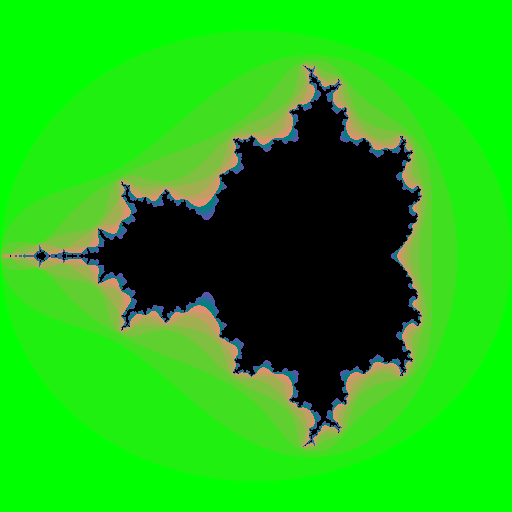

In [40]:
from PIL import Image
from IPython.display import Image as I
from IPython.display import display
import threading

w = 512 # image width
h = 512 # image height
image = Image.new("RGB", (w, h))
wh = w * h
maxIt = 12 # max number of iterations allowed
# drawing region (xa < xb & ya < yb)
xa = -2.0
xb = 1.0
ya = -1.5
yb = 1.5
xd = xb - xa
yd = yb - ya
numThr = 5 # number of threads to run
# lock = threading.Lock()

class ManFrThread(threading.Thread): 
    def __init__ (self, k):
          self.k = k
          threading.Thread.__init__(self)
    def run(self):
        # each thread only calculates its own share of pixels
        for i in range(k, wh, numThr):
            kx = i % w
            ky = int(i / w)
            a = xa + xd * kx / (w - 1.0)
            b = ya + yd * ky / (h - 1.0)
            x = a
            y = b
            for kc in range(maxIt):
                x0 = x * x - y * y + a
                y = 2.0 * x * y + b
                x = x0                
                if x * x + y * y > 4:
                    # various color palettes can be created here
                    red = (kc % 8) * 32
                    green = (16 - kc % 16) * 16
                    blue = (kc % 16) * 16
                    # lock.acquire()
                    global image
                    image.putpixel((kx, ky), (red, green, blue))
                    # lock.release()
                    break


tArr = []
for k in range(numThr): # create all threads
    tArr.append(ManFrThread(k))
for k in range(numThr): # start all threads
    tArr[k].start()
for k in range(numThr): # wait until all threads finished
    tArr[k].join()
image.save("MandelbrotFractal.png", "PNG")
i = I(filename='MandelbrotFractal.png')
display(i)

#####Modified from http://code.activestate.com/recipes/577680-multi-threaded-mandelbrot-fractal/

# Pipe AND queue communication
- Let's get crazy
- Subprocess to pipe to threads

In [41]:
from subprocess import Popen, PIPE
from threading import Thread
from Queue import Queue, Empty

io_q = Queue()

# Sticks anything from the pipe into a queue
def stream_watcher(identifier, stream):
    for line in stream:
        io_q.put((identifier, line))
    if not stream.closed:
        stream.close()

# Takes things out of the queue and prints them to the screen as they come
def printer():
    while True:
        try:
            # Block for 1 second.
            item = io_q.get(True, 1)
            
        except Empty:
            # No output in either streams for a second. Are we done?
            if proc.poll() is not None:
                break
        else:
            identifier, line = item
            print identifier + ':', line

command = "ls -l".split(" ")

proc = Popen(command, cwd='/usr/local/bin', stdout=PIPE, stderr=PIPE)

stdout_t = Thread(target=stream_watcher,
        args=('STDOUT', proc.stdout))
stderr_t = Thread(target=stream_watcher,
        args=('STDERR', proc.stderr))

stdout_t.daemon = True; stderr_t.daemon = True
stdout_t.start(); stderr_t.start()

print_t = Thread(target=printer)
print_t.daemon = True
print_t.start()

Modified from http://sharats.me/the-ever-useful-and-neat-subprocess-module.html#a-simple-usage

#Questions?